**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (100 points + 20 bonus points)  
Author: Luca and Umut

In [84]:
# Group number: 24
# Franka Buytenhuijs, s4356845
# Hugo Chateau-Laurent, s1023970
# Maria Tsfasman, s1021505

In [85]:
gpu = True

In [120]:
from chainer import cuda, datasets, serializers, optimizers
from chainer.dataset import DatasetMixin, concat_examples
import chainer.iterators as iterators
from chainer.iterators import MultithreadIterator

import chainer
import chainer.functions as F
import chainer.links as L

import matplotlib.pyplot as plt
import numpy
if gpu:
    import cupy as np
else:
    import numpy as np
import tqdm
import os
import IPython

This is the decoder class. It transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and y is latents.

Task: (10 points)

- Implement the decoder class for a variational autoencoder. Note that the decoder should output the Gaussian distribution parameters (mean and variance per pixel) of images rather than images themselves.

In [121]:
class Decoder(chainer.ChainList):
    def __init__(self, n_hlay, n_z, n_h, n_x): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        
        # Parameters:
        #  n_hlay: number of hidden layers
        #  n_z: dimension of latent space
        #  n_h: dimension of hidden layers (if n_hlay>0)
        #  n_x: dimension of x_out (=dimension of x_in)
        
        links=()
        
        if(n_hlay>0):
            links += (L.Linear(n_z, n_h),)
            for _ in range(n_hlay-1):
                links += (L.Linear(n_h, n_h),)
            n_z = n_h
        
        links += (L.Linear(n_z, n_x),) # mean
        links += (L.Linear(n_z, n_x),) # variance
        
        print('Decoder:', len(links))
                
        super(Decoder, self).__init__(*links)

    def __call__(self, z):         
        for layer in self[:-2]:
            z = F.relu(layer(z))       
        mean = F.relu(self[-2](z))
        var = F.relu(self[-1](z))
        
        
        return mean, var


This is the encoder class. It transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables.

Task: (10 points)

- Implement the encoder class for a variational autoencoder. Note that the encoder should output the Gaussian distribution parameters (mean and variance per feature) of features rather than features themselves.

In [122]:
class Encoder(chainer.ChainList):
    def __init__(self, n_hlay, n_x, n_h, n_z): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        
        # Parameters:
        #  n_hlay: number of hidden layers
        #  n_x: dimension of x_out (=dimension of x_in)
        #  n_h: dimension of hidden layers (if n_hlay>0)
        #  n_z: dimension of latent space

        links=()
        
        if(n_hlay>0):
            links += (L.Linear(n_x, n_h),)
            for _ in range(n_hlay-1):
                links += (L.Linear(n_h, n_h),)
            n_x = n_h
        
        links += (L.Linear(n_x, n_z),) # mean
        links += (L.Linear(n_x, n_z),) # variance
        
        print('Encoder:', len(links))
                
        super(Encoder, self).__init__(*links)

    def __call__(self, x):  
        for layer in self[:-2]:
            x = F.relu(layer(x))       
        mean = F.relu(self[-2](x))
        var = F.relu(self[-1](x))
        
        
        return mean, var


This is the loss class. The loss of encoder and decoder of a variational autoencoder is the evidence lower bound as follows:

$L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

The first term above is the KL divergence between the approximate posterior (q) and the prior (p), which can be interpreted as a form of regularization. You can assume that the prior is unit Gaussian. It can be implemented with the F.gaussian_kl_divergence function in Chainer.

The second term above is the Gaussian negative log likelihood. This is the term that fits the data, which is very similar to the usual loss functions that you use in deep learning. It can be implemented with the F.gaussian_nll function in Chainer.

Task: 

- Implement the loss class. (10 points)

As input, it gets the following arguments:

mean_y => mean of the encoded features (output of the encoder)  
ln_var_y => log variance of the encoded features (output of the encoder)  
x => input images (mini batch)  
mean_x => mean of the decoded images (output of the decoder)  
ln_var_x => mean of the decoded images (output of the decoder)  

As output, it gives the loss.

- Explain why we use log variance instead of variance. (5 points)

    <span style="color:blue">https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig</span>
    

In [162]:
class Loss(object):
    def __call__(self, mean_z, ln_var_z, x, mean_x, ln_var_x):
        return F.gaussian_kl_divergence(mean_z, ln_var_z) + F.gaussian_nll(x, mean_x, ln_var_x)

This is the model class. It combines the encoder and the decoder.

Task: (20 points)

- Implement the reparameterziation trick for sampling latents. (10 points)
- Explain why we need to use this trick. (10 points)

    <span style="color:blue">As drawing a sample from a normal distribution is a stochastic process, you cannot backpropagate through it. The trick is to separate the parameters you want to optimize from the random process.</span>

In [163]:
class Model(chainer.Chain):
    def __init__(self, decoder, encoder):
        super(Model, self).__init__()

        with self.init_scope():
            self.decoder = decoder
            self.encoder = encoder

    def __call__(self, x):
        ln_var_z, mean_z = self.encoder(x)
                
        #z = np.random.normal()*ln_var_z+mean_z # Sample latents (z) from the Gaussian with parameters ln_var_z, mean_z by using the reparameterization trick
        z = F.gaussian(mean_z, ln_var_z)
        
        ln_var_x, mean_x = self.decoder(z)

        return mean_z, ln_var_z, x, mean_x, ln_var_x
    

This is a helper class to use the Mnist dataset.

In [164]:
class Mnist(DatasetMixin):
    def __init__(self):
        self.dataset = datasets.get_mnist(False)[0 if chainer.config.train else 1]

    def __len__(self):
        return len(self.dataset)

    def get_example(self, i):
        return self.dataset[i]

Task: (50 points)

- Train the above defined variational autoencoder on the Mnist dataset. You can refer to the earlier assignments to implement your training loop. (25 points)

- How good are the samples? Randomy sample some digits and visualize them. (10 points)

- How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original. (10 points)

- Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results. (5 points)

In [169]:
class Optimizer():
    def __init__(self, model):
        self.model = model
        self.log = {'training':[], 'test':[]}   
        self.optimizer = optimizers.Adam()
        self.optimizer.setup(self.model)
        self.loss = Loss()
        
    def test(self, x, show=False):
        with chainer.using_config('train', False):
            mean_z, ln_var_z, x, mean_x, ln_var_x = self.model(x)
            if show:
                plt.imshow(np.asnumpy(mean_x.data[0]).reshape(28,-1), cmap='gray')
                plt.show()
            err = self.loss(mean_z, ln_var_z, x, mean_x, ln_var_x)   
            return float(err.data)
    
    def train(self, x):
        err = self.loss(*self.model(x)) # Forward propagation 
        self.model.cleargrads()
        err.backward() # backpropagation
        self.optimizer.update() 
        return float(err.data)
    
    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))
        serializers.load_npz('{}/weights.npz'.format(directory), self.model)
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)

        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        serializers.save_npz('{}/weights.npz'.format(directory), self.model)
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

load = False
# model from scratch
encoder = Encoder(2,784, 500,20) # (n_hlay, n_x, n_h, n_z)
decoder = Decoder(2,20, 500,784) # (n_hlay, n_z, n_h, n_x)
vae = Model(decoder, encoder)

if gpu:
    vae.to_gpu()
optimizer = Optimizer(vae)   

if load:
    optimizer.load("./Models/100")
if gpu:
    optimizer.model.to_gpu()
    

epochs = 100
batch_size = 50

training_set = Mnist()
test_set = Mnist()
training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
test_iterator = iterators.SerialIterator(test_set , batch_size, False, False)


Encoder: 4
Decoder: 4


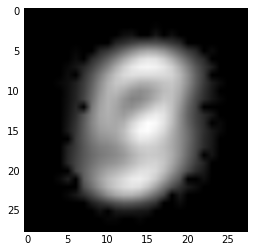

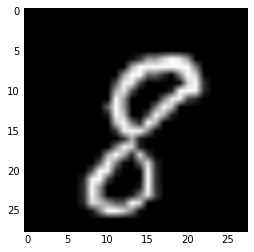

[37369.12179036458, 37361.70372721354, 37358.41555989583, 37354.48713867187, 37354.11581705729, 37349.05362955729, 37348.869817708335, 37347.98527669271, 37347.713935546875, 37347.067626953125, 37345.566380208336, 37345.56222330729, 37345.5217578125, 37345.52458333333, 37345.53687174479, 37345.41672526042, 37345.472835286455, 37345.55047526042, 37345.441787109376, 37345.40938802083]
[37397.042763671874, 37363.67306315104, 37359.94621744792, 37356.27958984375, 37354.257552083334, 37353.18081705729, 37348.53659830729, 37348.21967122396, 37347.983505859374, 37347.448606770835, 37346.01603841146, 37345.6120703125, 37345.52607421875, 37345.51955078125, 37345.53318033854, 37345.537135416664, 37345.552418619794, 37345.54203450521, 37345.48154947917, 37345.480345052085]


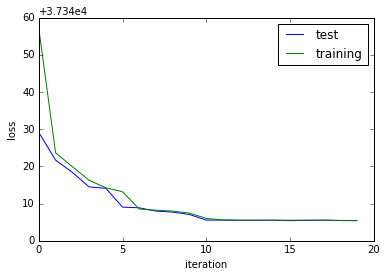

In [ ]:
# Create new folder to avoid FileExistsError
root = '.'
i=-1
path = '{}/Models'.format(root)
if not os.path.isdir(path):
    os.makedirs(path)
while i==-1 or os.path.isdir(path):
    i+=1
    path = '{}/Models/Weights_{}'.format(root, i)
os.makedirs('{}/Models/Weights_{}'.format(root, i))

optimizer.log['training'] = []
optimizer.log['test'] = []

for epoch in tqdm.tnrange(epochs):
    
    training_iterator.reset()
    test_iterator.reset()
    
    mean_loss = []
    for j, batch in enumerate(training_iterator):
        mean_loss.append(optimizer.train(np.array(batch)))
    optimizer.log['training'] += [numpy.mean(mean_loss)]

    mean_loss = []
    for j, batch in enumerate(test_iterator):
        mean_loss.append(optimizer.test(np.array(batch)))
    optimizer.log['test'] += [numpy.mean(mean_loss)]
    
    IPython.display.clear_output()
    
    optimizer.test(np.array(batch), show=True)
    plt.imshow(batch[0].reshape(28,-1), cmap='gray')
    plt.show()
    
    # store weights and loss
    os.makedirs('{}/{}'.format(path, epoch))
    optimizer.save('{}/{}'.format(path, epoch))
    
    print(optimizer.log['test'])
    print(optimizer.log['training'])
    
    plt.plot(range(epoch+1), optimizer.log['test'], label='test')
    plt.plot(range(epoch+1), optimizer.log['training'], label='training')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()    
    plt.show()

Bonus task: Try the same experiments on a different dataset. (20 bonus points)